In [15]:
from closestRecipe import ClosestRecipe
import pandas as pd

In [16]:
cr = ClosestRecipe()

In [17]:
#this cell demonstrates output of sorting all recipes by distance as a function of an input zip code;
#changing the zip code will alter resulting dataframe
zip_code = '30082'
ranked_recipe_df = cr.recipe_rank_zip(zip_code)

In [18]:
#this cell sets a lat/ lon position from zip code center &
#demonstrates calculating the mean distance for all recipes from a given input location
lat_long = cr.zip_lookup_lat_long(zip_code)
print('the center of that zip code is at: ' + str(lat_long))
average_recipe_distance_by_lat_long = cr.recipe_rank_avg_lat_long(lat_long)[0][0]
print('the average distance of all recipes from that input location is ' + str(average_recipe_distance_by_lat_long) + ' miles.')

the center of that zip code is at: (33.8631, -84.5382)
the average distance of all recipes from that input location is 86.78924486381766 miles.


In [19]:
ranked_with_ingredients = cr.recipe_rank_ings_zip(zip_code)
#ranked_with_ingredients.head()

In [20]:
pd.merge(cr.recipe_rank_zip('30082'), cr.recipe_rank_ings_zip('30082'), on='uid_recipe_title')

,avg_dist,recipe,uid_recipe_title,uid_lat_long,distance,uid_recipe_ings,lat,long,recipe_ingredients
0,1.906704,Green Bean Salad with Radishes and Prosciutto,63,796,5,159,33.939940,-84.574166,radish
1,1.906704,Green Bean Salad with Radishes and Prosciutto,63,796,5,78,33.939940,-84.574166,prosciutto
2,1.906704,Green Bean Salad with Radishes and Prosciutto,63,1199,65,140,34.069515,-85.654242,green bean
3,1.906704,Ambrosia,72,6386,379,186,31.535216,-90.453566,orange
4,1.906704,Ambrosia,72,6386,379,225,31.535216,-90.453566,grape
...,...,...,...,...,...,...,...,...,...
56817,728.195304,"White Bean, Butternut Squash, Kale and Olive S...",16772,797,6,201,33.790034,-84.468182,olive
56818,728.195304,"White Bean, Butternut Squash, Kale and Olive S...",16772,5132,51,62,34.317588,-83.818497,bean
56819,728.195304,"White Bean, Butternut Squash, Kale and Olive S...",16772,1941,1,16,33.883266,-84.515511,kale
56820,728.195304,"White Bean, Butternut Squash, Kale and Olive S...",16772,5700,87,115,34.852424,-85.506201,bell pepper


In [ ]:
#this cell generates a chloropleth for average distance of all recipes from all possible county centers in the 
#contiguous United States
#this function takes time to run (approx. 30 minutes locally on laptop)
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import folium


def chloropleth():
    county_geo = '../data/location/US_counties.geojson'

    df = gpd.read_file(county_geo, driver='GeoJSON')

    # Set to contiguous United States to limit range of mean distances and widen distribution for visualization
    alpha = df[~df['STATEFP'].isin(['02','15','60','66','69','72','78'])].reset_index()
    

    #creating normalized dataframes
    COUNTY_COORD = alpha[['NAME','INTPTLAT','INTPTLON','GEOID']].reset_index().rename(columns = {'index':'uid_lat_long','GEOID':'geo_id','INTPTLAT':'lat','INTPTLON':'long'})
    
    #setting as float
    COUNTY_COORD.lat = COUNTY_COORD.lat.astype(float)
    COUNTY_COORD.long = COUNTY_COORD.long.astype(float)
    
    COUNTY_COORD.loc[:,'mean_distance'] = COUNTY_COORD.apply(lambda x: cr.recipe_rank_avg_lat_long((x.lat,x.long))[0][0], axis = 1)
    
    #Create Choloropleth map from data
    # Initialize the map to contiguous states:
    m = folium.Map(location=[37, -102], zoom_start=5)
    # Add the color for the chloropleth:
    m.choropleth(geo_data=county_geo,
                         fill_color='YlGn', fill_opacity=0.5, line_opacity=0.5,
                         data = COUNTY_COORD,
                         key_on='feature.properties.GEOID',
                         columns = ['geo_id', 'mean_distance']
                         ) 
    m.save('../data/counties_mean_distance.html')

#un-comment the following line to run
chloropleth()


[Text(0, 0.5, '% recipes closer'), Text(0.5, 0, 'recipe average distance')]

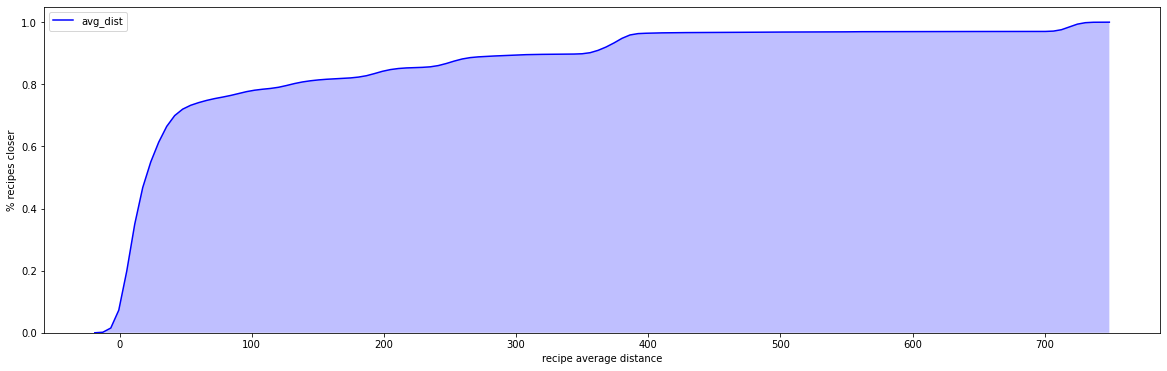

In [22]:
try:
    import statsmodels.nonparametric.api as smnp
    _has_statsmodels = True
except ImportError:
    _has_statsmodels = False



#the cell generates a cumulative density function of recipe distances from a given user input location
import seaborn as sns
import matplotlib.pyplot as plt
def dist_plot(x):
    plt.figure(figsize=(20, 6))
    mcdf = sns.kdeplot(x['avg_dist'], cumulative=True, shade=True, color="b").set(
        xlabel='recipe average distance', ylabel='% recipes closer')
    return mcdf

display(dist_plot(cr.recipe_rank_zip('30082')))

In [24]:
# a little preview on the recipe rank for my zip
cr = ClosestRecipe()

# a little preview on the recipe rank for my zip
recipe_rank = cr.recipe_rank_zip('30082')
recipe_rank

closest_ingredients = cr.recipe_rank_ings_zip('30082')
closest_ingredients

rank_recipe_and_ingredients = pd.merge(recipe_rank, closest_ingredients, on='uid_recipe_title')
rank_recipe_and_ingredients

# tiny bit of cleanup
rank_recipe_and_ingredients['recipe'] = rank_recipe_and_ingredients['recipe'].str.strip()

def face_mapper(df, lat_long, recipe=None, singlemap=True, centroid=None, bounds=None):
    
#   preprocessing for making charts
    if recipe:
        df_ = df[df['recipe']==recipe]
    else:
        df_ = df
        pass
    user_lat_long = lat_long
    lats = df_['lat']
    longs = df_['long']
    popups = df_['recipe_ingredients']
    
    # constructing map
    # add user point
    if singlemap:
        m= folium.Map(
            location=user_lat_long
        )
        # single user marker
        folium.Marker(location=user_lat_long).add_to(m)
        m.fit_bounds([[lats.min(), longs.min()], [lats.max(), longs.max()]])
    else:
        m=folium.Map(
            location=centroid
        )
        m.fit_bounds(bounds)
    
    # should have investigated memoization and annotations more here
    from collections import defaultdict
    cache = defaultdict(lambda: defaultdict(list))
    def repeat_cache(s, _type, v):
        if _type == 'lines':
            cache[_type][s].append(1)
        if _type == 'markers':
            cache[_type][s].append(v)

    # makes the lines
    def make_poly_lines(s):
        p2 = (s['lat'], s['long'])
        if p2 not in cache['lines']:
            folium.PolyLine(
                locations=[user_lat_long, p2],
                weight=2
            ).add_to(m)
        repeat_cache(p2, 'lines', None)

    # makes the popup
    def make_popup_(s):
        popup = ',\n'.join([x for x in set(s)])
        return popup

    # makes the markers
    def make_markers(s):
        p = (s['lat'], s['long'])
        if p not in cache['markers']:
            popup= make_popup_(df_[df_['uid_lat_long']==s['uid_lat_long']]['recipe_ingredients'])
            folium.Marker(
                p, 
                popup=folium.Popup(popup, max_width=100, max_height=200)
            ).add_to(m)
        repeat_cache(p, 'markers', s['recipe_ingredients'])

    # loops through the dataframe (could use some enhancements)
    for s in df_.iterrows():
        make_poly_lines(s[1])
        make_markers(s[1])

    # return map for each zip
    return m

display(face_mapper(rank_recipe_and_ingredients, cr.lat_long))

In [25]:
zips = [30082,48109,80211]
def centroid_(coordinates):
    import math

    x = 0.0
    y = 0.0
    z = 0.0

    for coord in coordinates:
        latitude = math.radians(coord[0])
        longitude = math.radians(coord[1])

        x += math.cos(latitude) * math.cos(longitude)
        y += math.cos(latitude) * math.sin(longitude)
        z += math.sin(latitude)

    total = len(coordinates)

    x = x / total
    y = y / total
    z = z / total

    central_longitude = math.atan2(y, x)
    central_square_root = math.sqrt(x * x + y * y)
    central_latitude = math.atan2(z, central_square_root)

    return math.degrees(central_latitude),math.degrees(central_longitude)

def get_bounds(dfs):
    lat_mins = []
    lat_maxs = []
    long_mins = []
    long_maxs = []
    for df in dfs:
        lat_mins.append(df['lat'].min())
        lat_maxs.append(df['lat'].max())
        long_mins.append(df['long'].min())
        long_maxs.append(df['long'].max())
    return [(min(lat_mins), max(lat_maxs)), (min(long_mins), max(long_maxs))]

def get_map(centroid, bounds):
    m=folium.Map(
        location=centroid
    )
    m.fit_bounds(bounds)
    return m

def construct_df_for_vis(_zip):
    rr = cr.recipe_rank_zip(_zip)
    recipe_rank_ = rr
    ri = cr.recipe_rank_ings_zip(_zip)
    df = pd.merge(rr, ri, on='uid_recipe_title')
    return df, cr.lat_long

def make_df_by_zip(zip_):
    if type(zip_) == list:
        dfs = []
        ulat_longs = []
        for z in zip_:
            df, ulat_long = construct_df_for_vis(z)
            dfs.append(df)
            ulat_longs.append(ulat_long)
        centroid = centroid_(ulat_longs)
        return dfs, ulat_longs, centroid
    if type(zip_) == str:
        df, ulat_long = construct_df_for_vis(zip_)
        return df, ulat_long


zips = [30082,48109,80211]
dfs, ulat_longs, centroid = make_df_by_zip(zips)
bounds = get_bounds(dfs)
m = get_map(centroid, bounds)
for i,df in enumerate(dfs):
    face_mapper(df, ulat_longs[i], m)
m
    


In [26]:

# start of setting stuff
def user_dfs_latlong_from_construct(zip_):
    zips = None
    try:
        zips = zip_.split(',')
    except Exception as e:
        pass
    
    if zips:
        dfs, ulat_longs, centroid = make_df_by_zip(zips)
        # set global variable here
        return dfs, ulat_longs, centroid
    else: 
        df, ulat_long, centroid = make_df_by_zip(zip_)
        # set global variable here
        return df, ulat_long, centroid

zip_ = '48109'
recipe_ranked_ = cr.recipe_rank_zip('48109')

@interact(
    recipe=widgets.Dropdown(
        options = recipe_ranked_['recipe']
    ) 
)
def make_maps(recipe):
    dfs, ulat_longs, centroid = user_dfs_latlong_from_construct(zip_)
    bounds = get_bounds(dfs)
    m = get_map(centroid, bounds)
    for i,df in enumerate(dfs):
        face_mapper(df, ulat_longs[i], m, recipe=recipe)
    return display(m)
#     display(make_maps('Green Bean Salad with Radishes and Prosciutto '))


NameError: name 'interact' is not defined